## Julian's rework of Rebecca Farringtons's property models.

Properties are now available in absolute and relative values of density and viscosity, cohesion and cohesion2

One can control absolute values or relative (i.e. Rebecca's original version) by setting the variable, 

`RELATIVE_VALS=1` # For relative values

`RELATIVE_VALS=0` # For absolute values


In [1]:
# critical variable, don't delete
RELATIVE_VALS=0

**Material parameters for Moresi el al (2014)**

This notebook outlines the material parameterisation used to model the dynamics of continental accretion as shown in Extended Data Figure 2 of [Moresi et al (2014) [doi:10.1038/nature13033](https://www.nature.com/articles/nature13033)

A number of functions must be defined
1. layer intersects of discretised lithospheric structure, a numpy array with dimensions of length [L]
2. depth, a numpy array with dimensions of length [L]
3. crustal density, rho(depth), a numpy array with dimensions of [M/L^3] 
4. temperature, temperature(depth), a numper array with dimensions of [T]
5. yield strength, yieldStrength(pressure), a numpy array with dimensions of pressure []. Pressure assumed to be lithostatic pressure.
6. softened yield strength, yieldStrength2(pressure), a numpy array with dimensions of pressure []. Pressure assumed to be lithostatic pressure.
7. viscous deformation law?

In [2]:
import underworld as uw
from underworld import function as fn

import numpy as np
import math
import scipy
import scipy.special as special
import os
import matplotlib.pyplot as pypl
import pint


In [3]:
u = pint.UnitRegistry()

**Define the layer intersections in the modelled lithosphere**

In [4]:
# for oceanic lithosphere, ExFig 5a, 5b
layers = np.array([0, 25, 50, 75, 100, 200]) * 1e3 * u.meter 
print('Numer of layers is {}'.format(len(layers)-1))
print('Interface at {}'.format(layers.to('km')))

Numer of layers is 5
Interface at [   0.   25.   50.   75.  100.  200.] kilometer


**Define depth**

In [5]:
res   = 251
depth = np.linspace(0, 250., res) * 1e3 * u.meter

**Define temperature**

In [6]:
Tsurf = 273.15 * u.degK
Tint  = 1573.0 * u.degK
kappa = 1e-6   * u.meter**2 / u.second 
alpha = 3.0e-5 / u.kelvin
grav  = 9.81   * u.meter / u.second**2
mantleDensity   = 3400 * u.kilogram / u.meter**3
mantleViscosity = 1e20 * u.Pa * u.sec

# temperature of oceanic lithosphere thickness
def half_space_cooling(depth,age):
    age = age.to('seconds')
    depth = depth.to('meters')
    return Tsurf +(Tint-Tsurf) * special.erf(depth/(2*np.sqrt(age*kappa)))

# temperature of cratonic lithosphere
def craton_linear_geotherm(depth):
    linear = depth.to('km')*(Tint-Tsurf)/(150.*u.km)+Tsurf
    return np.minimum(linear.m,Tint)*linear.units

# temperature of transition lithosphere
def transition_linear_geotherm(depth):
    linear = depth.to('km')*(Tint-Tsurf)/(100.*u.km)+Tsurf
    return np.minimum(linear.m,Tint)*linear.units

# temperature of backarc lithosphere
def backarc_linear_geotherm(depth):
    linear = depth.to('km')*(Tint-Tsurf)/(80.*u.km)+Tsurf
    return np.minimum(linear.m,Tint)*linear.units

# lambda function to create depth profiles:
# note, the pint dimensionaly of all the inputs are SI units
# rho0-depth, must use '.m' as np.where() can use pint dimensionality
rho0_y = lambda c_t, c_d: np.where(depth.m > c_t.m_as('m'), mantleDensity.m, c_d.m) * u.kg / u.m**3

# density-depth
density_y = lambda rho, T: rho * (1. - alpha * (T - Tsurf) )

# pressure-depth
pressure_y = lambda d: d * grav * depth

# wet diffusion creep - Karato & Wu, 1993
E = 240. * 10**3 * u.joule / u.mol
V = 5.0  * 1e-6 * u.meter**3 / u.mol
R = 8.314  * u.joule / u.degK / u.mol

arrhenius_y = lambda T,P: np.exp((E + V*P)/(R*T))

# reference parameters taken from LM's paper
ref_depth     = 100. * 10**3 *u.meter   
ref_pressure  = mantleDensity * grav * ref_depth
ref_temp      = Tint
ref_viscosity = arrhenius_y(ref_temp, ref_pressure)
ref_density   = mantleDensity * (Tint-Tsurf) * alpha

def build_depth_profiles(cT, cD, mD, mV, T, P=None):
    """
    cT, cD - crust thikness and crust density
    mD     - mantle density
    mV     - mantle viscosity
    T      - temperature depth profile (vector array)
    P      - pressure depth profile (vector), build it if needed
    
    Returns depth profiles for density, pressure and viscosity.
    Viscosity will be normalized at depth 100km using a temperature 1573K = 1e20 Pa s
    """
    # calculate associated profiles with depth.
    # all numpy arrays are of length == len(depth)
    rho0        = rho0_y(crustThickness, crustDensity)
    density     = density_y(rho0,temperature)
    
    # LM paper uses oceanic slab pressure profile to construct ALL profiles
    # Hence we have the option to REUSE it here.
    if P is None: pressure = pressure_y(density)
    else:         pressure = P
    
    arr_scaling = arrhenius_y(temperature, pressure)
    
    # LM's viscosity factor ref_viscosity is taken from 2014 paper
    # Question: shouldn't is  be 1/arrhenius_y(Tint, pressure[100].to(u.Pa))
    if RELATIVE_VALS == 1: vLM = 1. / ref_viscosity 
    else:                  vLM = 1e20 * u.Pa * u.second / ref_viscosity
    
    viscosity = arr_scaling * vLM
    
    return density, pressure, viscosity
   

In [7]:
# younger oceanic lithosphere parameters
age             = 80. * 10**6 * u.year
crustThickness  = 7.0  * u.km
crustDensity    = 2900 * u.kilogram / u.meter**3 # Oceanic crust (cold basalt)
if RELATIVE_VALS == 0:
    max_viscosity   = 1e25 * u.Pa * u.sec
    min_viscosity   = 1e20 * u.Pa * u.sec
else:
    max_viscosity   = 1e5
    min_viscosity   = 1

In [8]:
# # calculate associated profiles with depth.
# using the half-space-cooling model define temperature and pressure profile
temperature = half_space_cooling(depth, age)


(density,pressure,viscosity) = build_depth_profiles(crustThickness, crustDensity,
                                                    mantleDensity, mantleViscosity, temperature)

# clip above 1e25 Pa s, and below 100km to 1e20 Pa s
viscosity = np.clip(viscosity, a_min=min_viscosity, a_max=max_viscosity)

In [9]:
# oceanic lithosphere       
cohesion = 12.5 * u.megapascal
friction = 0.0666
cohesion2 = cohesion/2.
friction2 = friction/2.  # is this needed for the oceanic lithosphere?

In [10]:
yieldStrength  = cohesion  + friction  * pressure
yieldStrength2 = cohesion2 + friction2 * pressure # post yeild strength

In [11]:
# # JG test ploting instead of plot function below
# def jPlot():
#     '''
#     Ploting of 2 windows:
#      - temperature and density plot
#      - viscosity and strength plots
     
#     Note the use of global numpy arrays by this function
#     '''
#     figure1 = pypl.figure(figsize=(12,8))
#     figure1.suptitle("title", fontsize=14, fontweight='bold')
#     tempPlot = figure1.add_subplot(121)
#     tempPlot.plot(temperature.m, depth.m_as('km'), color='red' , linestyle='solid', linewidth=2)
#     tempPlot.set_xlim((0, 2000)); 
#     tempPlot.set_xlabel('Temperature (K)')
#     tempPlot.set_ylabel('depth (km)') ; 
#     tempPlot.set_ylim(0, 250); 
#     tempPlot.invert_yaxis()
#     tempPlot.set_yticks([0,25,50,75,100,200,250])
#     tempPlot.grid(axis='y')

#     densityPlot = tempPlot.twiny()
#     densityPlot.plot(density.m, depth.m_as('km'), color='blue' , linestyle='solid', linewidth=2)
#     densityPlot.set_xlabel('Density (kg/m$^3$)')
#     # densityPlot.set_xlim((0, 3500))
#     densityPlot.set_ylim(0, 250)
#     densityPlot.invert_yaxis()
#     densityPlot.set_yticks([0,25,50,75,100,200,250])
#     densityPlot.grid(axis='y')

#     viscPlot = figure1.add_subplot(122)
#     viscPlot.plot(viscosity.m, depth.m_as('km'), color='red' , linestyle='solid', linewidth=2)
#     # viscPlot.set_xlim((viscosity.m.min(), viscosity.m.max())); 
#     viscPlot.set_xlabel('Viscosity (Pa.s)')
#     viscPlot.set_ylabel('depth (km)') ; 
#     viscPlot.set_xscale('log')
#     viscPlot.set_ylim(0, 250); 
#     viscPlot.invert_yaxis()
#     viscPlot.set_yticks([0,25,50,75,100,200,250])
#     viscPlot.grid(axis='y')
    
#     strengthPlot = viscPlot.twiny()
#     strengthPlot.plot(yieldStrength.m, depth.m_as('km'), color='green' , linestyle='solid', linewidth=2)
#     strengthPlot.plot(yieldStrength2.m, depth.m_as('km'), color='purple' , linestyle='solid', linewidth=2)
#     # viscPlot.set_xlim((viscosity.m.min(), viscosity.m.max())); 
#     strengthPlot.set_xlabel('Strength (Pa)')
#     strengthPlot.set_ylabel('depth (km)') ; 
#     strengthPlot.set_ylim(0, 250); 
#     strengthPlot.invert_yaxis()
#     strengthPlot.set_yticks([0,25,50,75,100,200,250])
#     strengthPlot.grid(axis='y')

# jPlot()

**Define viscous deformation**

In [12]:
 # calculate averages of layers
avg_depth      = []
avg_temp       = []
avg_density    = []
avg_pressure   = []
avg_viscosity  = []
avg_strength   = []
low_strength   = []
avg_strength2  = []
low_strength2  = []

def init_avg():
    # reset the averages - ugly global sorry
    g = globals()
    avg_depth.clear()
    avg_temp.clear()
    g['avg_density'].clear()
    g['avg_pressure'].clear()
    g['avg_viscosity'].clear()
    g['avg_strength'].clear()
    g['low_strength'].clear()
    g['avg_strength2'].clear()
    g['low_strength2'].clear()

    

def calc_layers():
    prevIndex = 0

    for l in layers:
        # no calc below 250 km
        if (l > 250*u.km): break

        # find depth index of layer
        index = np.where(depth.to(layers.units)==l)[0][0]

        # take averages. Must have distrinct layers, prevIndex != index
        if prevIndex != index:
            
            # First process density: relative or absolute values depend on RELATIVE_VALS
            if RELATIVE_VALS: 
                temp = np.average((density.m[prevIndex:index]-density.m[-1])/ref_density)
            else: 
                temp = np.average(density.m[prevIndex:index])
            avg_density.append( temp )
            
            avg_viscosity.append( 
                np.average(viscosity.m[prevIndex:index]) )
            avg_depth.append( 
                np.average(depth.m_as('km')[prevIndex:index]) )
            avg_temp.append( 
                np.average(temperature.m_as('K')[prevIndex:index]) )
            avg_pressure.append(  
                np.average(pressure.m_as('MPa')[prevIndex:index]))
            avg_strength.append(  
                np.average(yieldStrength.m_as('MPa')[prevIndex:index]))
            avg_strength2.append( 
                np.average(yieldStrength2.m_as('MPa')[prevIndex:index]))
            low_strength.append(  
                np.min( yieldStrength.m_as('MPa')[prevIndex:index]))
            low_strength2.append( 
                np.min( yieldStrength2.m_as('MPa')[prevIndex:index]))

        prevIndex = index

In [13]:
init_avg()
calc_layers()

**Plot material properties within layers**

**Figure 2(a) Half-space cooling - 80 Myr Oceanic Lithosphere**

In [14]:
def plot(title,height,densityPlot_xlim,relDensityPlot_xlim,strengthPlot_xlim,viz_strength_layer):
    figure1 = pypl.figure(figsize=(12,8))
    figure1.suptitle(title, fontsize=14, fontweight='bold')

    # Temperature and Viscosity profiles
    tempPlot = figure1.add_subplot(131)
    tempPlot.plot(temperature.m_as('degC'), depth.m_as('km'), color='green', linestyle='solid', linewidth=2, label='')
    tempPlot.set_xlabel('Temperature (C)')
    tempPlot.set_ylabel('Depth (km)')
    tempPlot.set_xlim(0,1500)
    tempPlot.set_ylim(250, 0)
    tempPlot.set_yticks([0,25,50,75,100,200,250])
    tempPlot.grid(axis='y')

    viscPlot = tempPlot.twiny()
    if RELATIVE_VALS==0: 
        viscPlot.plot(np.log10(viscosity.m), depth.m_as('km'), color='blue', linestyle='solid', linewidth=2)
        viscPlot.set_xlabel('log$_{10}$viscosity')
    else:
        viscPlot.set_xlabel('log$_{10}$ relative viscosity')
        viscPlot.set_xlim(0, 7)
        
    viscPlot.set_ylim(0, 250)
    viscPlot.invert_yaxis()
    viscPlot.barh(layers.m[0:-1]/10**3,np.log10(avg_viscosity), height=height, left=0.0, alpha=0.5, align="edge")

    # Density profile
    densityPlot = figure1.add_subplot(132)
    densityPlot.plot(density.m, depth.m_as('km'), color='red' , linestyle='solid', linewidth=2)
    densityPlot.set_xlabel('Density (kg/m$^3$)')
    densityPlot.set_xlim(densityPlot_xlim)
    densityPlot.set_ylim(0, 250)
    densityPlot.invert_yaxis()
    densityPlot.set_yticks([0,25,50,75,100,200,250])
    densityPlot.grid(axis='y')

    relDensityPlot = densityPlot.twiny()
    if RELATIVE_VALS==0: 
        relDensityPlot.set_xlabel('Density')
    else:
        relDensityPlot.set_xlabel('Relative Density')
#         relDensityPlot.set_xlim(relDensityPlot_xlim)
        
    relDensityPlot.axvline(x=0, ymin=0, ymax=1, linestyle='dotted', color='black')
    relDensityPlot.set_ylim(250,0)
    relDensityPlot.barh(layers.m[0:-1]/10**3,avg_density, height=height, left=0.0, alpha=0.5, color='#FF2222', align="edge")

    # lithostatic pressure and strength profile
    pressurePlot = figure1.add_subplot(133)
    pressurePlot.set_xlabel('Pressure (Mpa)')
    pressurePlot.set_yticks([0,25,50,75,100,200,250])
    pressurePlot.plot(pressure.m_as('MPa'), depth.m_as('km'), color='DarkGreen', linestyle='dashed', linewidth=2)
    pressurePlot.set_xticks([0,2500,5000,7500,10000])
    pressurePlot.set_ylim(0, 250)
    pressurePlot.invert_yaxis()
    pressurePlot.set_xlim(0, 7500)
    pressurePlot.grid(axis='y')

    strengthPlot = pressurePlot.twiny()
    strengthPlot.set_xlabel('Yield strength (Mpa)')
    strengthPlot.set_ylim(250,0)
    strengthPlot.set_xlim(strengthPlot_xlim)
    strengthPlot.plot(yieldStrength.m_as('MPa'), depth.m_as('km'), color='green', linestyle='solid', linewidth=2, label='Yield strength (MPa)')
    strengthPlot.barh(layers[0:viz_strength_layer]/10**3, low_strength[0:viz_strength_layer], 
                      height=height[0:viz_strength_layer], left=0.0, alpha=0.5, color='green', align="edge")
    strengthPlot.barh(layers[0:viz_strength_layer]/10**3, low_strength2[0:viz_strength_layer], 
                      height=height[0:viz_strength_layer], left=0.0, alpha=0.5, color='darkgreen', align="edge")


/usr/lib/python3.7/site-packages/pint/quantity.py:1377: UnitStrippedWarning: The unit of the quantity is stripped.
  warnings.warn("The unit of the quantity is stripped.", UnitStrippedWarning)


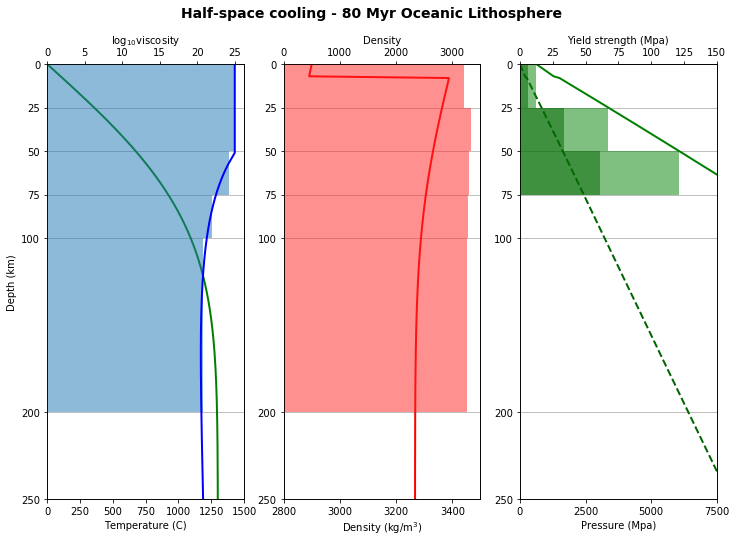

In [15]:
height=(layers.magnitude[1:] - layers.magnitude[0:-1])/1e3
title = 'Half-space cooling - 80 Myr Oceanic Lithosphere'
densityPlot_xlim    = (2800,3500)
# relDensityPlot_xlim = (-0.35, 0.6)
relDensityPlot_xlim = (0, 3700)
strengthPlot_xlim   = (0, 150)
viz_strength_layer  = 3

plot(title,height,densityPlot_xlim,relDensityPlot_xlim,strengthPlot_xlim,viz_strength_layer)

In [16]:
print(title)
print('layer\t avg_viscosity\t avg_density\t low_strength\t low_strength2 ')
for i, j in enumerate(avg_viscosity):
    print('{0:.1f};\t {1:.5e};\t {2:.5e};\t {3:.5e};\t {4:.5e};\t'
          .format(layers.magnitude[i+1]/1e3, avg_viscosity[i], avg_density[i], low_strength[i], low_strength2[i]))

Half-space cooling - 80 Myr Oceanic Lithosphere
layer	 avg_viscosity	 avg_density	 low_strength	 low_strength2 
25.0;	 1.00000e+25;	 3.22255e+03;	 1.25000e+01;	 6.25000e+00;	
50.0;	 1.00000e+25;	 3.34755e+03;	 6.74388e+01;	 3.37194e+01;	
75.0;	 1.92964e+24;	 3.31851e+03;	 1.21324e+02;	 6.06619e+01;	
100.0;	 9.64084e+21;	 3.29701e+03;	 1.74498e+02;	 8.72492e+01;	
200.0;	 5.02961e+20;	 3.27418e+03;	 2.27355e+02;	 1.13678e+02;	


In [17]:
init_avg()

**Figure 2(b) Half-space cooling - 120 Myr Oceanic Lithosphere**

In [18]:
age = 120. * 10**6 * u.year
temperature = half_space_cooling(depth, age)

(density,pressure,viscosity) = build_depth_profiles(crustThickness, crustDensity,
                                                    mantleDensity, mantleViscosity, temperature, pressure)

viscosity = np.clip(viscosity, a_min=min_viscosity, a_max=max_viscosity)

yieldStrength  = cohesion  + friction  * pressure
yieldStrength2 = cohesion2 + friction2 * pressure # post yeild strength

In [19]:
calc_layers()

/usr/lib/python3.7/site-packages/pint/quantity.py:1377: UnitStrippedWarning: The unit of the quantity is stripped.
  warnings.warn("The unit of the quantity is stripped.", UnitStrippedWarning)


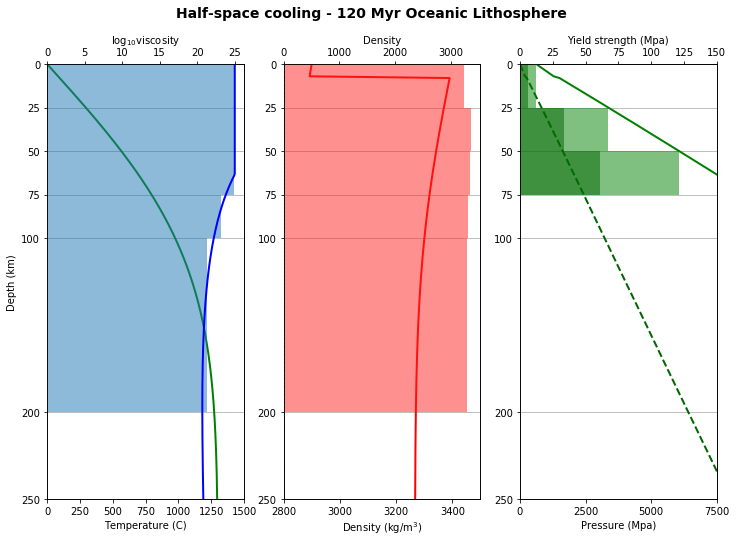

In [20]:
height=(layers.magnitude[1:] - layers.magnitude[0:-1])/1e3
title = 'Half-space cooling - 120 Myr Oceanic Lithosphere'
densityPlot_xlim    = (2800,3500)
relDensityPlot_xlim = (-0.2, 0.6)
strengthPlot_xlim   = (0, 150)
viz_strength_layer  = 3

plot(title,height,densityPlot_xlim,relDensityPlot_xlim,strengthPlot_xlim,viz_strength_layer)

In [21]:
print(title)
print('layer\t avg_viscosity\t avg_density\t low_strength\t low_strength2 ')
for i, j in enumerate(avg_viscosity):
    print('{0:.1f};\t {1:.5e};\t {2:.5e};\t {3:.5e};\t {4:.5e};\t'
          .format(layers.magnitude[i+1]/1e3, avg_viscosity[i], avg_density[i], low_strength[i], low_strength2[i]))

Half-space cooling - 120 Myr Oceanic Lithosphere
layer	 avg_viscosity	 avg_density	 low_strength	 low_strength2 
25.0;	 1.00000e+25;	 3.22571e+03;	 1.25000e+01;	 6.25000e+00;	
50.0;	 1.00000e+25;	 3.35648e+03;	 6.74388e+01;	 3.37194e+01;	
75.0;	 7.03180e+24;	 3.33075e+03;	 1.21324e+02;	 6.06619e+01;	
100.0;	 1.58728e+23;	 3.30973e+03;	 1.74498e+02;	 8.72492e+01;	
200.0;	 2.25864e+21;	 3.28108e+03;	 2.27355e+02;	 1.13678e+02;	


**Figure 2(c) Cratonic Lithosphere**

In [22]:
init_avg()

In [23]:
# define layers
layers = np.array([0, 75, 150, 200]) * 10**3 * u.meter 

# define crust thickness and density
crustThickness  = 40.0  * u.km
crustDensity    = 2700 * u.kilogram / u.meter**3 

In [24]:
# define density (reference and with depth)
temperature = craton_linear_geotherm(depth)
(density,pressure,viscosity) = build_depth_profiles(crustThickness, crustDensity,
                                                    mantleDensity, mantleViscosity, temperature, pressure )

### modify clip
if RELATIVE_VALS == 0:
    max_viscosity   = 5e23 * u.Pa * u.sec
    min_viscosity   = 1e20 * u.Pa * u.sec
else:
    max_viscosity   = 5e3
    min_viscosity   = 1

viscosity = np.clip(viscosity, a_min=min_viscosity, a_max=max_viscosity)

cohesion = 130.*u.megapascal
cohesion2 = cohesion / 2.
yieldStrength  = cohesion  + friction  * pressure
yieldStrength2 = cohesion2 + friction2 * pressure # post yeild strength

In [25]:
calc_layers()

/usr/lib/python3.7/site-packages/pint/quantity.py:1377: UnitStrippedWarning: The unit of the quantity is stripped.
  warnings.warn("The unit of the quantity is stripped.", UnitStrippedWarning)


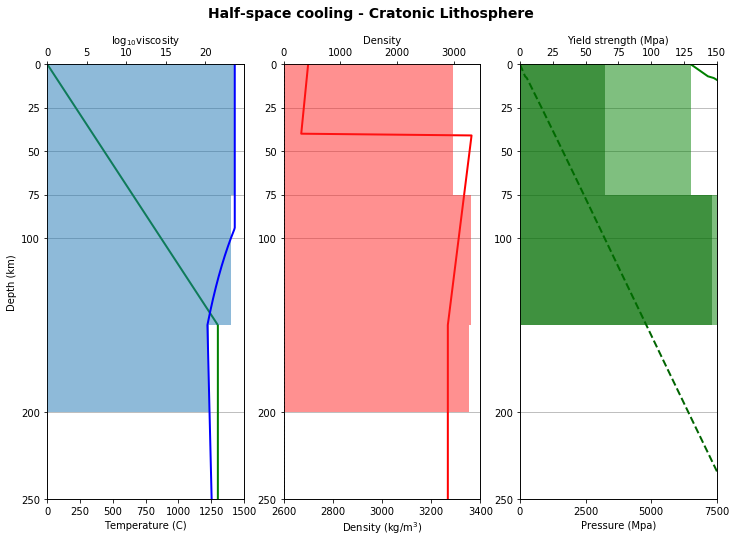

In [26]:
height=(layers.magnitude[1:] - layers.magnitude[0:-1])/1e3
title = 'Half-space cooling - Cratonic Lithosphere'
densityPlot_xlim    = (2600,3400)
relDensityPlot_xlim = (-2.0, 1.0)
strengthPlot_xlim   = (0, 150)
viz_strength_layer  = 2

plot(title,height,densityPlot_xlim,relDensityPlot_xlim,strengthPlot_xlim,viz_strength_layer)

In [27]:
print(title)
print('layer\t avg_viscosity\t avg_density\t low_strength\t low_strength2 ')
for i, j in enumerate(avg_viscosity):
    print('{0:.1f};\t {1:.5e};\t {2:.5e};\t {3:.5e};\t {4:.5e};\t'
          .format(layers.magnitude[i+1]/1e3, avg_viscosity[i], avg_density[i], low_strength[i], low_strength2[i]))

Half-space cooling - Cratonic Lithosphere
layer	 avg_viscosity	 avg_density	 low_strength	 low_strength2 
75.0;	 5.00000e+23;	 2.98662e+03;	 1.30000e+02;	 6.50000e+01;	
150.0;	 1.67484e+23;	 3.30100e+03;	 2.91998e+02;	 1.45999e+02;	
200.0;	 2.41107e+20;	 3.26742e+03;	 4.50665e+02;	 2.25332e+02;	


In [28]:
init_avg()

**Figure 2(d) Transitional Lithosphere**

In [29]:
# define layers
layers = np.array([0, 50, 100, 200]) * 10**3 * u.meter 

# # transition lithosphere
crustThickness  = 25.0  * u.km
crustDensity    = 2700 * u.kilogram / u.meter**3 

temperature = transition_linear_geotherm(depth)
(density,pressure,viscosity) = build_depth_profiles(crustThickness, crustDensity,
                                                    mantleDensity, mantleViscosity, temperature)

viscosity = np.clip(viscosity, a_min=min_viscosity, a_max=max_viscosity)

In [30]:
# transitional lithosphere strength profiles
yieldStrength = np.zeros(res)*u.megapascal
def trans_yeildStrength(depth):
    for index, y in enumerate(depth):
        if y < 50.*u.km:
            yieldStrength[index] = 40.*u.megapascal
        elif y < 100.*u.km:
            yieldStrength[index] = 150.*u.megapascal
    return yieldStrength

# yieldStrength  = np.ones(res)*40.*u.megapascal
trans_yeildStrength(depth)
yieldStrength2 = yieldStrength/2.

In [31]:
#avg_depth, avg_temp, avg_density, avg_pressure, avg_viscosity, avg_strength, avg_strength2, low_strength, low_strength2 = calc_layers()
calc_layers()

/usr/lib/python3.7/site-packages/pint/quantity.py:1377: UnitStrippedWarning: The unit of the quantity is stripped.
  warnings.warn("The unit of the quantity is stripped.", UnitStrippedWarning)


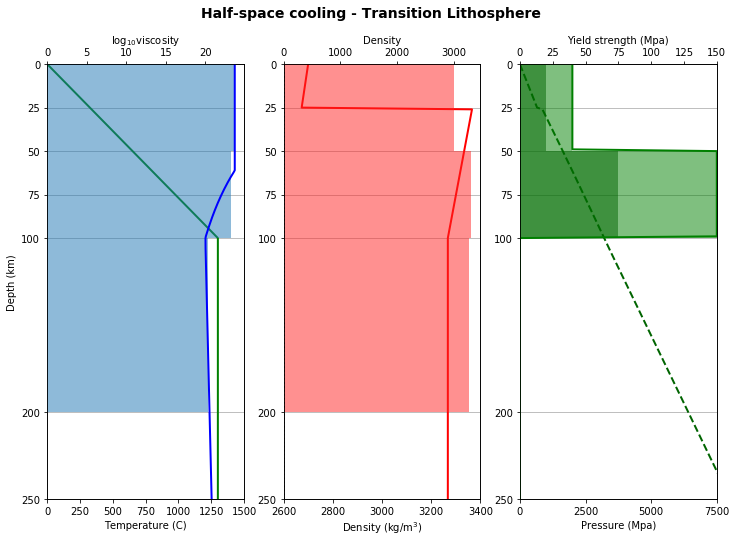

In [32]:
height=(layers.magnitude[1:] - layers.magnitude[0:-1])/1e3
title = 'Half-space cooling - Transition Lithosphere'
densityPlot_xlim    = (2600,3400)
relDensityPlot_xlim = (-2.0, 1.0)
strengthPlot_xlim   = (0, 150)
viz_strength_layer  = 2

plot(title,height,densityPlot_xlim,relDensityPlot_xlim,strengthPlot_xlim,viz_strength_layer)

In [33]:
print(title)
print('layer\t avg_viscosity\t avg_density\t low_strength\t low_strength2 ')
for i, j in enumerate(avg_viscosity):
    print('{0:.1f};\t {1:.5e};\t {2:.5e};\t {3:.5e};\t {4:.5e};\t'
          .format(layers.magnitude[i+1]/1e3, avg_viscosity[i], avg_density[i], low_strength[i], low_strength2[i]))

Half-space cooling - Transition Lithosphere
layer	 avg_viscosity	 avg_density	 low_strength	 low_strength2 
50.0;	 5.00000e+23;	 3.00529e+03;	 4.00000e+01;	 2.00000e+01;	
100.0;	 1.50142e+23;	 3.30122e+03;	 1.50000e+02;	 7.50000e+01;	
200.0;	 1.85773e+20;	 3.26742e+03;	 0.00000e+00;	 0.00000e+00;	


In [34]:
init_avg()

**Figure 2(e) Weak back-arc Lithosphere**

In [35]:
# define layers
layers = np.array([0, 50, 100, 200]) * 10**3 * u.meter 

# back-arc lithosphere
crustThickness  = 20.0  * u.km
crustDensity    = 2800 * u.kilogram / u.meter**3 

def backarc_linear_geotherm2(depth):
    linear = depth.to('km')*(Tint-Tsurf)/(80.*u.km)+Tsurf
    return np.minimum(linear.magnitude,Tint)*linear.units

temperature = backarc_linear_geotherm2(depth)
(density,pressure,viscosity) = build_depth_profiles(crustThickness, crustDensity,
                                                    mantleDensity, mantleViscosity, temperature)

# clip above 1e25 Pa s, and below 100km to 1e20 Pa s
# viscosity = np.where(viscosity.m>1e25, 1e25, viscosity.m) * u.Pa * u.s
# viscosity[100:] = 1e20 * u.Pa * u.s

viscosity = np.clip(viscosity, a_min=min_viscosity, a_max=max_viscosity)

In [36]:
# back arc weak
yieldStrength = np.zeros(res)*u.megapascal
def backarc_yeildStrength(depth):
    for index, y in enumerate(depth):
        if y < 50.*u.km:
            yieldStrength[index] = 12.5*u.megapascal
        elif y < 100.*u.km:
            yieldStrength[index] = 25.0*u.megapascal
    return yieldStrength

backarc_yeildStrength(depth)
yieldStrength2 = yieldStrength/2.

In [37]:
#avg_depth, avg_temp, avg_density, avg_pressure, avg_viscosity, avg_strength, avg_strength2, low_strength, low_strength2 = calc_layers()
calc_layers()


/usr/lib/python3.7/site-packages/pint/quantity.py:1377: UnitStrippedWarning: The unit of the quantity is stripped.
  warnings.warn("The unit of the quantity is stripped.", UnitStrippedWarning)


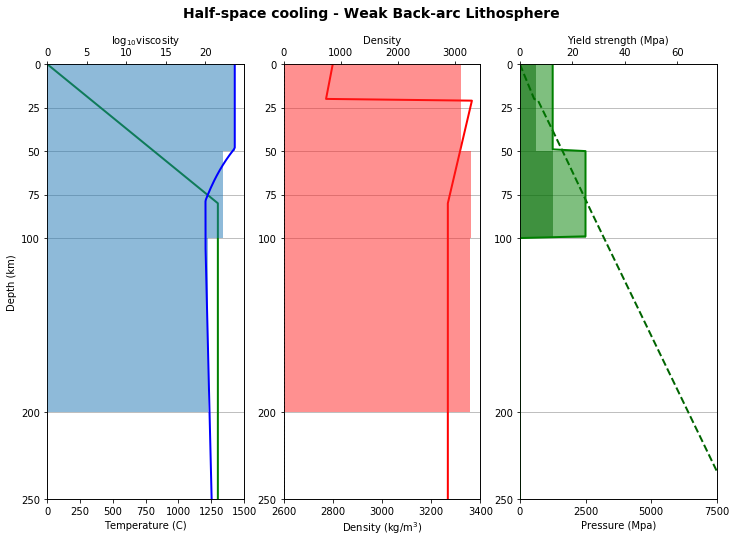

In [38]:
height=(layers.magnitude[1:] - layers.magnitude[0:-1])/1e3
title = 'Half-space cooling - Weak Back-arc Lithosphere'
densityPlot_xlim    = (2600,3400)
relDensityPlot_xlim = (-2.0, 1.0)
strengthPlot_xlim   = (0, 75)
viz_strength_layer  = 2

plot(title,height,densityPlot_xlim,relDensityPlot_xlim,strengthPlot_xlim,viz_strength_layer)

In [39]:
print(title)
print('layer\t avg_viscosity\t avg_density\t low_strength\t low_strength2 ')
for i, j in enumerate(avg_viscosity):
    print('{0:.1f};\t {1:.5e};\t {2:.5e};\t {3:.5e};\t {4:.5e};\t'
          .format(layers.magnitude[i+1]/1e3, avg_viscosity[i], avg_density[i], low_strength[i], low_strength2[i]))

Half-space cooling - Weak Back-arc Lithosphere
layer	 avg_viscosity	 avg_density	 low_strength	 low_strength2 
50.0;	 4.97782e+23;	 3.10862e+03;	 1.25000e+01;	 6.25000e+00;	
100.0;	 1.71934e+22;	 3.28283e+03;	 2.50000e+01;	 1.25000e+01;	
200.0;	 1.85773e+20;	 3.26742e+03;	 0.00000e+00;	 0.00000e+00;	


In [40]:
init_avg()

**Figure 2(e) Strong back-arc Lithosphere**

In [41]:
# back arc strong
yieldStrength = yieldStrength * 2.
yieldStrength2 = yieldStrength2 * 2.

In [42]:
#avg_depth, avg_temp, avg_density, avg_pressure, avg_viscosity, avg_strength, avg_strength2, low_strength, low_strength2 = calc_layers()
calc_layers()


/usr/lib/python3.7/site-packages/pint/quantity.py:1377: UnitStrippedWarning: The unit of the quantity is stripped.
  warnings.warn("The unit of the quantity is stripped.", UnitStrippedWarning)


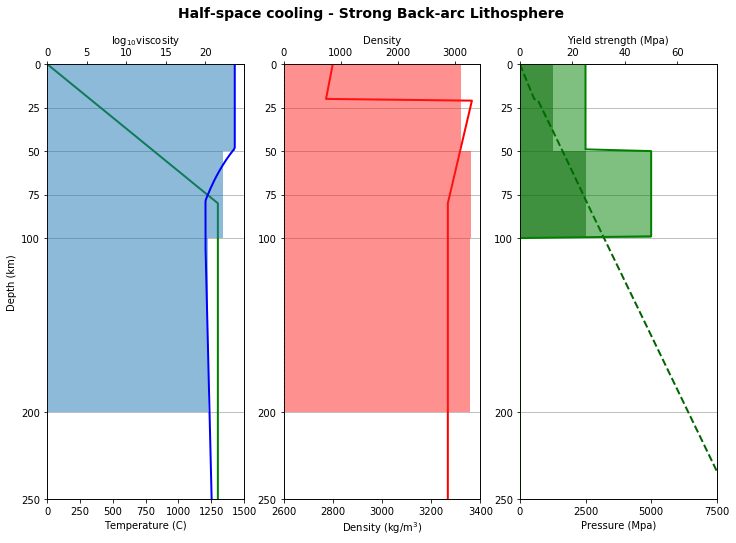

In [43]:
height=(layers.magnitude[1:] - layers.magnitude[0:-1])/1e3
title = 'Half-space cooling - Strong Back-arc Lithosphere'
densityPlot_xlim    = (2600,3400)
relDensityPlot_xlim = (-2.0, 1.0)
strengthPlot_xlim   = (0, 75)
viz_strength_layer  = 2

plot(title,height,densityPlot_xlim,relDensityPlot_xlim,strengthPlot_xlim,viz_strength_layer)

In [44]:
print(title)
print('layer\t avg_viscosity\t avg_density\t low_strength\t low_strength2 ')
for i, j in enumerate(avg_viscosity):
    print('{0:.1f};\t {1:.5e};\t {2:.5e};\t {3:.5e};\t {4:.5e};\t'
          .format(layers.magnitude[i+1]/1e3, avg_viscosity[i], avg_density[i], low_strength[i], low_strength2[i]))

Half-space cooling - Strong Back-arc Lithosphere
layer	 avg_viscosity	 avg_density	 low_strength	 low_strength2 
50.0;	 4.97782e+23;	 3.10862e+03;	 2.50000e+01;	 1.25000e+01;	
100.0;	 1.71934e+22;	 3.28283e+03;	 5.00000e+01;	 2.50000e+01;	
200.0;	 1.85773e+20;	 3.26742e+03;	 0.00000e+00;	 0.00000e+00;	
